# PSO para otimizar pesos de MLP 

In [3]:
using Distributions
using CSV
using Plots
using DataFrames
using Random

In [4]:
Random.seed!(123);

### MLP

In [5]:
function init_params(n_in::Int64, n_h::Int64)
    W1 = rand(Uniform(-1/sqrt(n_h+n_in),1/sqrt(n_h+n_in)),n_h, n_in)
    b1 = rand(Uniform(-1/sqrt(n_h),1/sqrt(n_h)),n_h)
    W2 = rand(Uniform(-1/sqrt(1+n_h),1/sqrt(1+n_h)), 1, n_h)
    b2 = rand(Uniform(-1,1), 1, 1)
    return [W1, b1, W2, b2]
end

function forward_prop(x, params)
    W1 = params[1]
    b1 = params[2]
    W2 = params[3]
    b2 = params[4]
    
    linear1 = W1 * x .+ b1
    linear2 = W2 * linear1 .+ b2
    out = 1.7159*tanh.(2/3*linear2)
    
    return out
end

function compute_cost(A2, y)
    m = size(y)[2]
    erro = A2 .- y
    cost = 1/m * sum(erro.^2)
    return cost
end

function params_array(params)
    W1 = parametros[1]
    b1 = parametros[2]
    W2 = parametros[3]
    b2 = parametros[4]
    lista_params = hcat(reshape(W1, 1,prod(size(W1))), reshape(b1, 1,prod(size(b1))), 
        reshape(W2, 1,prod(size(W2))), reshape(b2, 1,prod(size(b2))))
    return lista_params
end

function params_reshape(lista_params, params)
    W1 = params[1]
    b1 = params[2]
    W2 = params[3]
    b2 = params[4]

    w1_dim_tot = prod(size(W1))
    b1_dim_tot = prod(size(b1))
    w2_dim_tot = prod(size(W2))
    b2_dim_tot = prod(size(b2))

    W1_reshaped = reshape(lista_params[1:w1_dim_tot], size(W1))
    id = w1_dim_tot
    b1_reshaped = reshape(lista_params[id+1:id+b1_dim_tot], size(b1))
    id += b1_dim_tot
    W2_reshaped = reshape(lista_params[id+1:id+w2_dim_tot], size(W2))
    id += w2_dim_tot
    b2_reshaped = reshape(lista_params[id+1:id+b2_dim_tot], size(b2))
    
    return [W1_reshaped, b1_reshaped, W2_reshaped, b2_reshaped]
    
end


params_reshape (generic function with 1 method)

### Importar dados

In [153]:
sunspot = CSV.read("dados/sunspot.csv"; delim=",")
sunspot_serie = sunspot["valor"];

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[153]:2
└ @ Core In[153]:2


In [154]:
sunspot_serie[1:10]

10-element Array{Float64,1}:
  5.0
 11.0
 16.0
 23.0
 36.0
 58.0
 29.0
 20.0
 10.0
  8.0

### Funções de normalização

In [155]:
# normalizar serie
function normalizar(serie)
    max = maximum(serie)
    min = minimum(serie)
    
    y_temp = 2 .* ((serie .- min)) ./ (max .- min) .- 1
    
    y = y_temp ./ sqrt(size(serie)[1])
    
    return y
end

function desnormalizar(serie_norm, serie)
    max = maximum(serie)
    min = maximum(serie)
    
    serie_temp = serie_norm .* sqrt(size(serie)[1])
    serie_temp2 = (serie_temp .+ 1)/2
    serie_temp3 = serie_temp2 * ((max - min) + min)
    return serie_temp3 
end

desnormalizar (generic function with 1 method)

In [156]:
function split_sequence(serie, n_steps_in::Int64)
    len = size(serie)[1]
    max_iter = len - n_steps_in
    seq_x = zeros(max_iter, n_steps_in)
    seq_y = zeros(max_iter)
    for i in 1:len-n_steps_in
        idx = i + n_steps_in - 1
        out_idx = idx + 1
        if out_idx > len
            println(i)
            println("len = ", len)
            println("out_idx = ", out_idx)
            println("Out_idx > len")
            break
        end
        seq_x[i,:] = serie[i:idx]
        seq_y[i] = serie[out_idx]
    end
    return seq_x, seq_y
end

split_sequence (generic function with 1 method)

### Função de split treino/val/teste

In [157]:
function divisao_dados_temporais(X, y, perc_treino::Float64, perc_val::Float64)
    tam_treino = convert(Int64, floor(perc_treino * size(y)[1]))
    
    if perc_val > 0
        tam_val = convert(Int64, floor(perc_val * size(y)[1]))
        X_treino = X[1:tam_treino,:]
        y_treino = y[1:tam_treino]
        
        X_val = X[tam_treino+1:tam_treino+1+tam_val,:]
        y_val = y[tam_treino+1:tam_treino+1+tam_val]
        
        X_teste = X[(tam_treino+tam_val+1):end,:]
        y_teste = y[(tam_treino+tam_val+1):end]
        
        return X_treino, y_treino, X_teste, y_teste,  X_val, y_val
        
    else
        X_treino = X[1:tam_treino,:]
        y_treino = y[1:tam_treino]
        
        X_teste = X[tam_treino+1:end,:]
        y_teste = y[tam_treino+1:end]
        return X_treino, y_treino, X_teste, y_teste
    end
end

divisao_dados_temporais (generic function with 1 method)

### Função do PSO

In [158]:
function PSO(X, y, params, n_particles::Int64, dim, max_iter::Int64, LB::Float64, UB::Float64, perc_treino::Float64, perc_val::Float64)
    
    mse_treino = zeros(size(y)[2]*max_iter)
    mse_val = zeros(size(y)[2]*max_iter)
    mse_teste = zeros(size(y)[2]*max_iter)
    
    particles = rand(n_particles, sum(dim))
    velocity = zeros(n_particles, sum(dim))
    pbest = particles
    gbest = pbest[1,:]
    
    parametros = params_reshape(gbest, params)
    y_pred = forward_prop(X[:,:,1]', parametros)
    gbest_value = compute_cost(y_pred, y[:,1]')    

    fitness_value = zeros(n_particles)

    for i in eachindex(fitness_value)
        parametros = params_reshape(particles[i,:], params)
        y_pred = forward_prop(X[:,:,1]', parametros)
        fitness_value[i] = compute_cost(y_pred, y[:,1]')
    end
    
    wmax = 0.9
    wmin = 0.4
    c1 = 1.5
    c2 = 1.5
    
    iteracao = 1
    for janela in 1:size(y)[2]
        
        X_treino, Y_treino, X_teste, Y_teste, X_val, Y_val = divisao_dados_temporais(X[:,:,janela], y[:,janela], perc_treino, perc_val)
        
        X_tv = vcat(X_treino, X_val)'
        Y_tv = vcat(Y_treino, Y_val)'

        for k in 1:max_iter
            w=wmax-(wmax-wmin)*k/max_iter
        

            for i in 1:n_particles
                for j in 1:sum(dim)
                    velocity[i, j] = w*velocity[i,j] + c1*rand()*(pbest[i,j] - particles[i,j]) + c2*rand()*(gbest[j] - particles[i,j])
                end
            end

            # update pso position
            for i in 1:n_particles
                for j in 1:sum(dim)
                    particles[i,j] = particles[i,j] + velocity[i,j]
                end
            end

            # handling boundary violations 
            for i in 1:n_particles
                for j in 1:sum(dim)
                    if particles[i,j]<LB 
                        particles[i,j]=LB 
                    elseif particles[i,j]>UB 
                        particles[i,j]=UB 
                    end
                end 
            end 

            # evaluating fitness
            for i in 1:n_particles
                parametros = params_reshape(particles[i,:], params)
                y_pred = forward_prop(X_treino', parametros)
                fitness_value[i] = compute_cost(y_pred, Y_treino')
            end

            # updating pbest and fitness
            for i in 1:n_particles
                parametros_pbest = params_reshape(pbest[i, :], params)
                y_pred_pbest = forward_prop(X_treino', parametros_pbest)
                if fitness_value[i] < compute_cost(y_pred_pbest, Y_treino')
                    pbest[i] = particles[i, :]
                end
            end

            # updating gbest 
            for i in 1:n_particles    
                if fitness_value[i] < gbest_value
                    gbest_value = fitness_value[i]
                    gbest = particles[i,:]   
                end
            end
    
            parametros_gbest = params_reshape(gbest, params)
            # treino e validacao mse
            A2_gbest_tv = forward_prop(X_tv, parametros_gbest)
            mse_tv = compute_cost(A2_gbest_tv, Y_tv)
            mse_treino[iteracao] = mse_tv
            #append!(mse_treino,mse_tv)

            # validacao mse
            A2_gbest_v = forward_prop(X_val', parametros_gbest)
            mse_v = compute_cost(A2_gbest_v, Y_val')
            mse_val[iteracao] = mse_v
            #append!(mse_val,mse_v)

            # teste
            A2_gbest_t = forward_prop(X_teste', parametros_gbest)
            mse_t = compute_cost(A2_gbest_t, Y_teste')
            mse_teste[iteracao] = mse_t
            #append!(mse_teste,mse_t)
            
            iteracao += 1
        end
    end
    return mse_treino, mse_val, mse_teste
end

PSO (generic function with 1 method)

In [159]:
function n_model_pso(X, y, n_h::Int64, num_iteracoes::Int64, perc_treino::Float64, perc_val::Float64)
    n_in = size(X)[2]
    parametros = init_params(n_in, n_h)
    
#     A2 = forward_prop(X', parametros)

#     best_cost = compute_cost(A2, y')
    
    W1 = parametros[1]
    b1 = parametros[2]
    W2 = parametros[3]
    b2 = parametros[4]
    
    dim_list = [prod(size(W1)), prod(size(b1)), prod(size(W2)), prod(size(b2))]
    
    qtd_particulas_dim = convert(Int64,(size(W1)[2] + 1) * size(W1)[1] + (size(W1)[1] + 1)* size(W2)[1])

    mse_treino, mse_val, mse_teste = PSO(X, y, parametros, qtd_particulas_dim, dim_list, num_iteracoes, -1.0, 1.0, perc_treino, perc_val)
        
    return mse_treino, mse_val, mse_teste
end

n_model_pso (generic function with 1 method)

### Função para criar os cenários dinâmicos

In [13]:
# janelamento para cenários dinâmicos
function cenarios_dinamicos(serie, window_size::Int64, step_size::Int64)
    
    if ndims(serie) == 1
        w = window_size
        s = step_size
        t = size(serie)[1]

        i_max = convert(Int64,floor((t-w)/s))

        s_temp = serie[(1*s):((1*s)+w-1)]

        cenarios = zeros(0)

        append!(cenarios, s_temp)

        for i in 2:i_max
            s_temp = serie[(i*s):((i*s)+w-1)]
            cenarios = hcat(cenarios, s_temp)
        end
        return cenarios
    else
        w = window_size
        s = step_size
        t = size(serie)[1]

        i_max = convert(Int64,floor((t-w)/s))

        s_temp = serie[(1*s):((1*s)+w-1), :]

        cenarios = zeros(w, size(X)[2], i_max)

        cenarios[:,:, 1] = s_temp

        for i in 2:i_max
            s_temp = serie[(i*s):((i*s)+w-1),:]
            cenarios[:, :, i] = s_temp
        end
        return cenarios
    end
end

cenarios_dinamicos (generic function with 1 method)

### Função para executar os cenários dinâmicos

In [14]:
# Criando cenários
function cenarios_execucoes_pso(X, y, w, s, f::Int64, perc_treino::Float64, perc_val::Float64,qtd_execucoes::Int64)
    
    # gerando os cenários dinâmicos
    X_I = cenarios_dinamicos(X, w, s)
    y_I = cenarios_dinamicos(y, w, s)
 
    # calculando a quantidade de iterações
    T = f * size(y_I)[2] 

    println("Quantidade de iterações: ", T)
    
    neuronios = 2:25
    
    mse_treino = zeros(qtd_execucoes, size(neuronios)[1], size(y_I)[2] * f)
    mse_val = zeros(qtd_execucoes, size(neuronios)[1], size(y_I)[2] * f)
    mse_teste = zeros(qtd_execucoes, size(neuronios)[1], size(y_I)[2] * f)
 
    execucoes = 1:qtd_execucoes

    for execucao in eachindex(execucoes)

        println("Execução: ", execucao)
        
        # Neuronios
        for (j,z) in zip(neuronios, eachindex(neuronios))
            
            println("Neurônios: ", j)
            
            mse_treino_lista_temp, mse_val_lista_temp, mse_teste_lista_temp = n_model_pso(X_I, y_I, j, f, perc_treino, perc_val)

            # salvar lista com os mse de treino para todas as iterações
            mse_treino[execucao, z,:] = mse_treino_lista_temp
            # salvar lista com os mse de validacao para todas as iteracoes
            mse_val[execucao, z,:] = mse_val_lista_temp
            # salvar lista com os mse de teste para todas as iterações
            mse_teste[execucao, z,:] = mse_teste_lista_temp

        end
    end
    return mse_treino, mse_val, mse_teste
end
            

cenarios_execucoes_pso (generic function with 1 method)

In [15]:
function avaliacao_resultados(mse_treino_cenarios, mse_val_cenarios, mse_teste_cenarios, f, quantidade_janelas, execucoes)
    
    mse_treino = Array{Float64, 2}(undef, execucoes, quantidade_janelas*f)
    #zeros(execucoes, quantidade_janelas*f)
    mse_teste = Array{Float64, 2}(undef, execucoes, quantidade_janelas*f)
    #zeros(execucoes, quantidade_janelas*f)
    
    for ex in 1:execucoes
        id_neuronios = Array{Int64, 1}(undef, quantidade_janelas)
        for janela in 1:quantidade_janelas
            id_neuronios[janela] = findmin(mse_val_cenarios[ex, :, f*janela])[2]
        end
        mse_treino[ex, 1:f] = mse_treino_cenarios[ex, id_neuronios[1], 1:f]
        mse_teste[ex, 1:f] = mse_teste_cenarios[ex, id_neuronios[1], 1:f]
        
        for jan in 1:quantidade_janelas
            if jan == quantidade_janelas
                mse_treino[ex, f*jan-f+1:f*jan] = mse_treino_cenarios[ex, id_neuronios[jan], f*jan-f+1:f*jan]
                mse_teste[ex, f*jan-f+1:f*jan] = mse_teste_cenarios[ex, id_neuronios[jan], f*jan-f+1:f*jan]
            else
                mse_treino[ex, f*jan+1:f*jan+f] = mse_treino_cenarios[ex, id_neuronios[jan], f*jan+1:f*jan+f]
                mse_teste[ex, f*jan+1:f*jan+f] = mse_teste_cenarios[ex, id_neuronios[jan], f*jan+1:f*jan+f]
            end
        end
    end
        
    qtd_iteracoes = size(mse_treino)[2]
    
    te = sum(mse_treino, dims = 2)./qtd_iteracoes
    ge = sum(mse_teste, dims = 2)./qtd_iteracoes

    gf = ge./te

    te_medio = mean(te)
    te_std = std(te)

    ge_medio = mean(ge)
    ge_std = std(ge)

    gf_medio = mean(gf)
    gf_std = std(ge)

    println("Te médio: ", te_medio)
    println("TE desvio: ", te_std)
    println("GE medio: ", ge_medio)
    println("GE desvio: ", ge_std)
    println("GF medio: ", gf_medio)
    println("GF desvio: ", gf_std)

    resultados = [te_medio, te_std, ge_medio, ge_std, gf_medio, gf_std]

    return resultados, mse_treino, mse_teste

end  

avaliacao_resultados (generic function with 1 method)

In [16]:
serie_norm = normalizar(sunspot_serie)
se = desnormalizar(serie_norm, sunspot_serie);

### Função de dividir os dados em X e Y

In [17]:
X, y = split_sequence(serie_norm, 10);

In [16]:
w = 60
s = 10
f = 50
quantidade_janelas = convert(Int64,floor((size(y)[1] - w)/s))

21

## Teste do PSO para Sunspot - Cenário 1 - 10 neurônios na camada escondida

In [ ]:
mse_treino, mse_val, mse_teste = cenarios_execucoes_pso(X, y, w, s, f, 0.54, 0.24, 3);

In [ ]:
resultados, mse_treino_r, mse_teste_r = avaliacao_resultados(mse_treino, mse_val, mse_teste, f, quantidade_janelas, 3);

In [96]:
plot(mse_treino_r[1, :], label = "Treino")
plot!(mse_teste_r[1,:], label = "Teste")

UndefVarError: UndefVarError: mse_treino_r not defined

## HIT
### Hourly internet traffic time series (HIT)

* 1657 obs.
* hourly 
* 19 nov 2004 at 9:30 and 27 jan 2005 at 11:11

Série horária: 24 inputs


In [ ]:
hit = CSV.read("dados/internet_traffic.csv"; delim=",")
hit = hit["valor"];

In [ ]:
qtd_inputs = 24
hit_norm = normalizar(hit)
X, y = split_sequence(hit_norm, 24);

### Cenário I

* w = 584
* s = 100
* f = 50

In [105]:
w = 584 # tamanho da janela
s = 100 # tamanho do passo
f = 50 # quantidade de iterações para a janela
T = convert(Int64,floor(f/s*(size(hit)[1]-w)+f))
println(T)
quantidade_janelas = convert(Int64,floor((size(y)[1] - w)/s))

UndefVarError: UndefVarError: hit not defined

In [ ]:
hit_mse_treino_1_pso, hit_mse_val_1_pso, hit_mse_teste_1_pso = cenarios_execucoes_pso(X, y, w, s, f, 0.54, 0.24, 3);

In [ ]:
methods(avaliacao_resultados)

In [114]:
hit_resultados_1_pso, hit_resultados_mse_treino_1_pso, hit_resultados_mse_teste_1_pso = avaliacao_resultados(hit_mse_treino_1_pso, hit_mse_val_1_pso, hit_mse_teste_1_pso, f, quantidade_janelas, 3)

UndefVarError: UndefVarError: hit_mse_treino_1_pso not defined

In [119]:
DataFrame(hit_resultados_1_pso')

In [121]:
CSV.write("resultados/hit_resultados_1_pso.csv", DataFrame(hit_resultados_1_pso'))
CSV.write("resultados/hit_resultados_mse_treino_1_pso.csv", DataFrame(hit_resultados_mse_treino_1_pso))
CSV.write("resultados/hit_resultados_mse_teste_1_pso.csv", DataFrame(hit_resultados_mse_teste_1_pso))

UndefVarError: UndefVarError: hit_resultados_1_pso not defined

### Cenário 2

* w = 584
* s = 250
* f = 100


In [ ]:
w = 584 # tamanho da janela
s = 250 # tamanho do passo
f = 100 # quantidade de iterações para a janela
T = convert(Int64, floor(f/s*(size(hit)[1]-w)+f))
print(T)
quantidade_janelas = convert(Int64,floor((size(y)[1] - w)/s))

In [ ]:
hit_mse_treino_2_pso, hit_mse_val_2_pso, hit_mse_teste_2_pso = cenarios_execucoes_pso(X, y, w, s, f, 0.54, 0.24, 3);

In [130]:
hit_resultados_2_pso, hit_resultados_mse_treino_2_pso, hit_resultados_mse_teste_2_pso = avaliacao_resultados(hit_mse_treino_2_pso, hit_mse_val_2_pso, hit_mse_teste_2_pso, f, quantidade_janelas,3)

UndefVarError: UndefVarError: hit_mse_treino_2_pso not defined

In [135]:
CSV.write("resultados/hit_resultados_2_pso.csv", DataFrame(hit_resultados_2_pso'))
CSV.write("resultados/hit_resultados_mse_treino_2_pso.csv", DataFrame(hit_resultados_mse_treino_2_pso))
CSV.write("resultados/hit_resultados_mse_teste_2_pso.csv", DataFrame(hit_resultados_mse_teste_2_pso))

### Cenário III

* w = 584
* s = 500
* f = 150


In [137]:
w = 584 # tamanho da janela
s = 500 # tamanho do passo
f = 150 # quantidade de iterações para a janela
T = convert(Int64, floor(f/s*(size(hit)[1]-w)+f))
print(T)
quantidade_janelas = convert(Int64,floor((size(y)[1] - w)/s))

UndefVarError: UndefVarError: hit not defined

In [140]:
hit_mse_treino_3_pso, hit_mse_val_3_pso, hit_mse_teste_3_pso = cenarios_execucoes_pso(X, y, w, s, f, 0.54, 0.24, 3);

UndefVarError: UndefVarError: X not defined

In [ ]:
hit_resultados_3_pso, hit_resultados_mse_treino_3_pso, hit_resultados_mse_teste_3_pso = avaliacao_resultados(hit_mse_treino_3_pso, hit_mse_val_3_pso, hit_mse_teste_3_pso, f, quantidade_janelas, 3)

In [144]:
CSV.write("resultados/hit_resultados_3_pso.csv", DataFrame(hit_resultados_3_pso'))
CSV.write("resultados/hit_resultados_mse_treino_3_pso.csv", DataFrame(hit_resultados_mse_treino_3_pso))
CSV.write("resultados/hit_resultados_mse_teste_3_pso.csv", DataFrame(hit_resultados_mse_teste_3_pso))

UndefVarError: UndefVarError: hit_resultados_3_pso not defined

## Cenário IV

* w = 584
* s = 584
* f = 100



In [147]:
w = 584 # tamanho da janela
s = 584 # tamanho do passo
f = 100 # quantidade de iterações para a janela
T = convert(Int64, floor(f/s*(size(hit)[1]-w)+f))
print(T)
quantidade_janelas = convert(Int64,floor((size(y)[1] - w)/s))

UndefVarError: UndefVarError: hit not defined

In [ ]:
hit_mse_treino_4, hit_mse_val_4, hit_mse_teste_4 = cenarios_execucoes_pso(X, y, w, s, f, 0.54, 0.24, 3);

In [151]:
hit_resultados_4_pso, hit_resultados_mse_treino_4_pso, hit_resultados_mse_teste_4_pso = avaliacao_resultados(hit_mse_treino_4_pso, hit_mse_val_4_pso, hit_mse_teste_4_pso, f, quantidade_janelas, 3)

UndefVarError: UndefVarError: hit_mse_treino_4_pso not defined

In [152]:
CSV.write("resultados/hit_resultados_4_pso.csv", DataFrame(hit_resultados_4_pso'))
CSV.write("resultados/hit_resultados_mse_treino_4_pso.csv", DataFrame(hit_resultados_mse_treino_4_pso))
CSV.write("resultados/hit_resultados_mse_teste_4_pso.csv", DataFrame(hit_resultados_mse_teste_4_pso))

UndefVarError: UndefVarError: hit_resultados_4_pso not defined

## Testando CQSO

In [189]:
sunspot = CSV.read("dados/sunspot.csv"; delim=",")
sunspot_serie = sunspot["valor"]
serie_norm = normalizar(sunspot_serie)
se = desnormalizar(serie_norm, sunspot_serie)
X, y = split_sequence(serie_norm, 10);

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[189]:2
└ @ Core In[189]:2


In [190]:
w = 60
s = 10
f = 50
quantidade_janelas = convert(Int64,floor((size(y)[1] - w)/s))

21

In [191]:
parameters = init_params(10, 10)
W1 = parameters[1]
b1 = parameters[2]
W2 = parameters[3]
b2 = parameters[4]

1×1 Array{Float64,2}:
 0.672591484908418

In [192]:
X_I = cenarios_dinamicos(X, w, s)
y_I = cenarios_dinamicos(y, w, s);

## CQSO 


In [129]:
function CQSO(X, y, params, n_particles::Int64, dim, max_iter::Int64, LB::Float64, UB::Float64, perc_treino::Float64, perc_val::Float64, neutral_p::Int64, rcloud::Float64)

    n = sum(dim)
    println("Dimensao: ", n)
    a = zeros(Int64, n)

    #a = Int64[]

    for i in 2:n
        if n%i == 0
            #push!(a, i)
            a[i] = i
        end
    end

    n_sub_swarms = sort(a[a.!=0])[1]

    # divide the dimensions per subswarm
    num = n
    div = n_sub_swarms

    dimensions_list = zeros(Int64, div)

    for x in 1:div
            if x < num % div
                dimensions_list[x] = 1 + (num ÷ div)
            else
                dimensions_list[x] = 0 + (num ÷ div)
            end
    end

    #context_vector = zeros(n_sub_swarms, n_sub_swarms)
    context_vector = zeros(n_sub_swarms, n)
    
    
    # Create a multiswarm and his velocities
    #multi_swarm_vector = zeros(n_sub_swarms, n_particles, dimensions_list[1])
    multi_swarm_vector = zeros(n_sub_swarms, n_particles, n)
    #velocity_vector = zeros(n_sub_swarms, n_particles, dimensions_list[1])
    velocity_vector = zeros(n_sub_swarms, n_particles, n)
    
    for i_subswarm in 1:n_sub_swarms
        #context_vector[i_subswarm, :] = rand(Uniform(-1.0, 1.0), n_sub_swarms)
        context_vector[i_subswarm, :] = rand(Uniform(-1.0, 1.0), n)
        for i_particle in 1:n_particles
            #multi_swarm_vector[i_subswarm, i_particle,:] = rand(Uniform(-1.0, 1.0), dimensions_list[1])
            multi_swarm_vector[i_subswarm, i_particle, :] = rand(Uniform(-1.0, 1.0), n)
        end
    end

    gbest = copy(multi_swarm_vector[1,1,:])
    pbest = copy(multi_swarm_vector[1,1,:])

    #sub_swarm_pbest = copy(context_vector)
    sub_swarm_pbest = copy(context_vector[1,:])
    parameters = copy(params)

    #parametros = params_reshape(reshape(context_vector, n), parameters)
    parametros = params_reshape(sub_swarm_pbest, parameters)
    
    y_pred = forward_prop(X[:,:,1]', parametros)
    gbest_value = compute_cost(y_pred, y[:, 1]')
    pbest_value = copy(gbest_value)

    parametros_gbest = copy(parametros)

    wmax = 0.9
    wmin = 0.4
    c1 = 1.5
    c2 = 1.5

    mse_treino = zeros(size(y)[2]*max_iter)
    mse_val = zeros(size(y)[2]*max_iter)
    mse_teste = zeros(size(y)[2]*max_iter)

    it_idx = 1

    for janela in 1:size(y)[2]

        X_treino, Y_treino, X_teste, Y_teste, X_val, Y_val = divisao_dados_temporais(X[:,:, janela], y[:, janela], perc_treino, perc_val)

        X_tv = vcat(X_treino, X_val)'
        Y_tv = vcat(Y_treino, Y_val)'

        # Iterações
        # Para cada sub_swarm em multi_swarm_vector
        iteration = 1
        while iteration < max_iter

            w=wmax-(wmax-wmin)*iteration/max_iter

            # for particula in sub_swarm
            for i_sub_swarm in 1:n_sub_swarms

                for i_particle in 1:n_particles

                    # Calcular o fitness 
                    context_copy = copy(context_vector)
                    #conetxt_copy = copy(context_vector[i_sub_swarm,:])

                    particle = copy(multi_swarm_vector[i_sub_swarm,i_particle,:])
                    context_copy[i_sub_swarm, :] = copy(particle)

                    #parameters_temp = params_reshape(reshape(context_copy, n), parameters)
                    #parameters_temp = params_reshape(reshape(context_copy[i_sub_swarm,:], n), parameters)
                    parameters_temp = params_reshape(context_copy[i_sub_swarm, :], parameters)
                    
                    A2_part = forward_prop(X_treino', parameters_temp)
                    fitness_candidate = compute_cost(A2_part, Y_treino')
                    
                    if fitness_candidate < pbest_value
                    # se o fitness da nova particula for melhor, ela vira o pbest
                        pbest = copy(multi_swarm_vector[i_sub_swarm, i_particle, :])
                        pbest_value = copy(fitness_candidate)
                        sub_swarm_pbest = copy(context_copy[i_sub_swarm, :])

                        # feito o pbest devemos atualizar as posições das particulas
                    end

                    if i_particle <= (neutral_p - 1)  

                        # atualiza como PSO vanilla
                        new_velocity = (w*velocity_vector[i_sub_swarm, i_particle, :]) .+ 
                        ((c1 * rand()) * (pbest .- multi_swarm_vector[i_sub_swarm, i_particle, :])) .+
                        ((c2 * rand()) * (gbest .- multi_swarm_vector[i_sub_swarm, i_particle, :]))

                        new_position = new_velocity .+ multi_swarm_vector[i_sub_swarm, i_particle, :]
                        
                    else
                        # atualiza como QSO
                        dist = sqrt(sum((multi_swarm_vector[i_sub_swarm, i_particle, :] .- gbest).^2))
                        #normal = rand(Normal(0,1), dimensions_list[i_sub_swarm])
                        normal = rand(Normal(0, 1), n)
                        #uniform = rand(dimensions_list[i_sub_swarm])
                        uniform = rand(n)
                        left_size_form = rcloud .* normal
                        
                        if dist == 0
                            break

                        end

                        right_size_form = (uniform.^(1/dimensions_list[i_sub_swarm])) ./ dist
                        new_position = left_size_form .* right_size_form
                        
                    end
                    # check if the positions is LB<x<UB
                    for i in eachindex(new_position) 
                                            
                        if new_position[i]<LB 
                            new_position[i]=LB 
                        elseif new_position[i]>UB 
                            new_position[i]=UB 
                        end
                    end 
                    
                    multi_swarm_vector[i_sub_swarm, i_particle, :] = copy(new_position)

                end   

                if pbest_value < gbest_value
                    gbest = copy(pbest)
                    gbest_value = copy(pbest_value)
                    context_vector[i_sub_swarm, :] = copy(sub_swarm_pbest)
                    parametros_gbest = copy(sub_swarm_pbest)
                end
            end
#            parameters_gbest = params_reshape(reshape(context_vector, n), parameters)
            #parameters_gbest = params_reshape(context_vector, parameters)    
            parameters_gbest = params_reshape(parametros_gbest, parameters)
            
            A2_gbest_tv = forward_prop(X_tv, parameters_gbest)
            mse_tv = compute_cost(A2_gbest_tv, Y_tv)
            mse_treino[it_idx] = mse_tv

            A2_gbest_v = forward_prop(X_val', parameters_gbest)
            mse_v = compute_cost(A2_gbest_v, Y_val')
            mse_val[it_idx] = mse_v

            A2_gbest_t = forward_prop(X_teste', parameters_gbest)
            mse_t = compute_cost(A2_gbest_t, Y_teste')
            mse_teste[it_idx] = mse_t

            iteration += 1

            it_idx += 1
                
            
        end

    end
    return mse_treino, mse_val, mse_teste   
end

CQSO (generic function with 1 method)

#### Teste do CQSO para Sunspot - 10 neurônios na camada escondida

In [184]:
n_h = 10
parameters = init_params(10, n_h)
qtd_particulas_dim = convert(Int64,(size(parameters[1])[2] + 1) * size(parameters[1])[1] + (size(parameters[1])[1] + 1)* size(parameters[3])[1])
dim_list = [prod(size(parameters[1])), prod(size(parameters[2])), prod(size(parameters[3])), prod(size(parameters[4]))]
LB = -1.0
UB = 1.0
perc_treino = 0.54
perc_val = 0.24
neutral_p = 25
rcloud = 0.2

0.2

In [193]:
Random.seed!(1);

#### PSO vs CQSO

In [194]:
@time mse_treino_pso, mse_val_pso, mse_teste_pso = PSO(X_I, y_I, parameters, qtd_particulas_dim, dim_list, f, LB, UB, perc_treino, perc_val)

 13.671984 seconds (42.02 M allocations: 7.972 GiB, 5.20% gc time)


([1.6485909776731817, 0.0344991856455898, 0.004659008914591625, 0.0026749306006832205, 0.0026749306006832205, 0.0026749306006832205, 0.0020222522845368815, 0.0018784913724140167, 0.0018784913724140167, 0.0019732017559833544  …  0.00047364699606166895, 0.00047364699606166895, 0.00047364699606166895, 0.00047364699606166895, 0.00047364699606166895, 0.00047364699606166895, 0.00047364699606166895, 0.00047364699606166895, 0.00047364699606166895, 0.00047364699606166895], [1.604156110721183, 0.010881433553030465, 0.0022847890425042087, 0.00195639458312873, 0.00195639458312873, 0.00195639458312873, 0.001027768913882236, 0.001152772121394452, 0.001152772121394452, 0.0016037803079746588  …  0.0010011524086803055, 0.0010011524086803055, 0.0010011524086803055, 0.0010011524086803055, 0.0010011524086803055, 0.0010011524086803055, 0.0010011524086803055, 0.0010011524086803055, 0.0010011524086803055, 0.0010011524086803055], [1.8100932062772488, 0.06995736881316378, 0.004140685813111493, 0.00342597558125

In [195]:
@time mse_treino_cqso, mse_val_cqso, mse_teste_cqso = CQSO(X_I, y_I, parameters, qtd_particulas_dim, dim_list, f, LB, UB, perc_treino, perc_val, neutral_p, rcloud)

Dimensao: 289
212.518014 seconds (411.30 M allocations: 384.997 GiB, 6.05% gc time)


([0.0005490233345350024, 0.0003472863262243891, 0.00030696254225330604, 0.00030262537763638126, 0.00028678367897750685, 0.0002338311110405023, 0.000200771044684985, 0.0001937223107162819, 0.0001418408781311713, 0.00013254972061928246  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.00038956487044783204, 0.00024866782665142965, 0.00025914077157730014, 0.00028970056626801305, 0.00027284886193272654, 0.0002212619838869262, 0.00017383364260231083, 0.00016697234625873624, 0.00012406069901773457, 0.00011201184791061098  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0015406303286129637, 0.0009455718303998359, 0.0008850932483332617, 0.0006994924990347838, 0.0006600270423678496, 0.0005893162711961211, 0.0005679375348540608, 0.0006072462329486014, 0.0003791061796769564, 0.0003295070038025195  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [196]:
println("Média mse treino PSO: ", mean(mse_treino_pso))
println("Média mse teste PSO: ", mean(mse_teste_pso))
println("Média mse treino CQSO: ", mean(mse_treino_cqso))
println("Média mse teste CQSO: ", mean(mse_teste_cqso))

Média mse treino PSO: 0.0018816194259545806
Média mse teste PSO: 0.002170768066044199
Média mse treino CQSO: 0.00016009018493643413
Média mse teste CQSO: 0.00021672807059916143


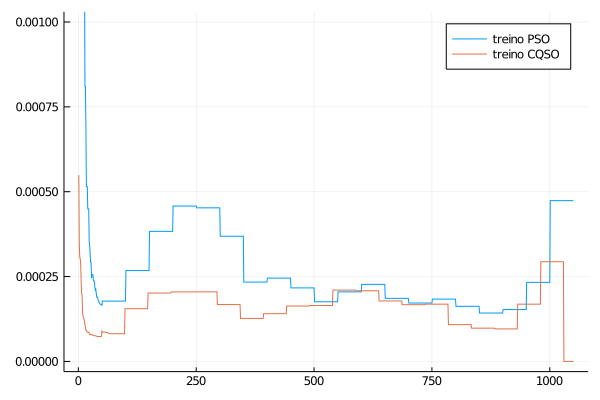

In [197]:
# plot(mse_treino_pso, label= "treino PSO", ylims = [0.0,0.001])
# plot!(mse_treino_cqso, label= "treino CQSO")
plot(mse_treino_pso, label= "treino PSO", ylims = [0.0, 0.001])
plot!(mse_treino_cqso, label= "treino CQSO")

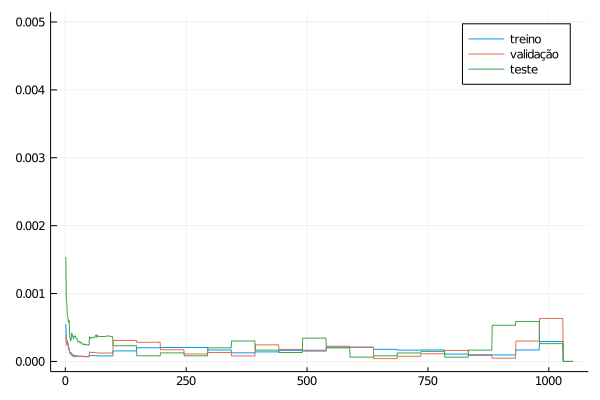

In [198]:
plot(mse_treino_cqso, label = "treino", ylims = [0.0,0.005])
plot!(mse_val_cqso, label = "validação")
plot!(mse_teste_cqso, label = "teste")

#### Função n_model_cqso para preparar o CQSO para rodar 

In [199]:
function n_model_cqso(X, y, n_h::Int64, num_iteracoes::Int64, perc_treino::Float64, perc_val::Float64, neutral_p::Int64, rcloud::Float64)
    
    n_in = size(X)[2]
    
    parametros = init_params(n_in, n_h)
    
    println("Neuronios: ", n_h)
#     A2 = forward_prop(X', parametros)

#     best_cost = compute_cost(A2, y')
    
    W1 = parametros[1]
    b1 = parametros[2]
    W2 = parametros[3]
    b2 = parametros[4]
    
    dim_list = [prod(size(W1)), prod(size(b1)), prod(size(W2)), prod(size(b2))]
    
    println("dim list: ", dim_list)
    
    qtd_particulas_dim = convert(Int64,(size(W1)[2] + 1) * size(W1)[1] + (size(W1)[1] + 1)* size(W2)[1])
    
    println("qtd particulas dim: ", qtd_particulas_dim)

    mse_treino, mse_val, mse_teste = CQSO(X, y, parametros, qtd_particulas_dim, dim_list, num_iteracoes, -1.0, 1.0, perc_treino, perc_val, neutral_p, rcloud)    
        
    return mse_treino, mse_val, mse_teste
end

n_model_cqso (generic function with 1 method)

#### Função Cenários execucoes CQSO

In [200]:
# Criando cenários
function cenarios_execucoes_cqso(X, y, w, s, f::Int64, perc_treino::Float64, perc_val::Float64,qtd_execucoes::Int64, netural_p::Int64, rcloud::Float64)
    
    # gerando os cenários dinâmicos
    X_I = cenarios_dinamicos(X, w, s)
    y_I = cenarios_dinamicos(y, w, s)
 
    # calculando a quantidade de iterações
    T = f * size(y_I)[2] 

    println("Quantidade de iterações: ", T)
    
    neuronios = 2:25
    
    mse_treino = zeros(qtd_execucoes, size(neuronios)[1], size(y_I)[2] * f)
    mse_val = zeros(qtd_execucoes, size(neuronios)[1], size(y_I)[2] * f)
    mse_teste = zeros(qtd_execucoes, size(neuronios)[1], size(y_I)[2] * f)
 
    execucoes = 1:qtd_execucoes

    for execucao in eachindex(execucoes)

        println("Execução: ", execucao)
        
        # Neuronios
        for (j,z) in zip(neuronios, eachindex(neuronios))
            
            mse_treino_lista_temp, mse_val_lista_temp, mse_teste_lista_temp = n_model_cqso(X_I, y_I, j, f, perc_treino, perc_val, neutral_p, rcloud)

            # salvar lista com os mse de treino para todas as iterações
            mse_treino[execucao, z,:] = mse_treino_lista_temp
            # salvar lista com os mse de validacao para todas as iteracoes
            mse_val[execucao, z,:] = mse_val_lista_temp
            # salvar lista com os mse de teste para todas as iterações
            mse_teste[execucao, z,:] = mse_teste_lista_temp

        end
    end
    return mse_treino, mse_val, mse_teste
end
            

cenarios_execucoes_cqso (generic function with 1 method)

### Teste cenários CQSO SUNSPOT - Cenário 1

In [201]:
@time sunspot_mse_treino_1_cqso, sunspot_mse_val_1_cqso, sunspot_mse_teste_1_cqso = cenarios_execucoes_cqso(X, y, w, s, f, 0.54, 0.24, 3, 25, 0.2)

Quantidade de iterações: 1050
Execução: 1
Neuronios: 2
dim list: [20, 2, 2, 1]
qtd particulas dim: 25
Dimensao: 25
Neuronios: 3
dim list: [30, 3, 3, 1]
qtd particulas dim: 37
Dimensao: 37


InterruptException: InterruptException: